In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = datasets.ImageFolder("../../data", transform=transform)
keep = {"Forest","Residential"}
keep_idx = [i for i,(_,y) in enumerate(full_dataset) if full_dataset.classes[y] in keep]
subset = Subset(full_dataset, keep_idx)

class_map = {full_dataset.class_to_idx["Forest"]:0, full_dataset.class_to_idx["Residential"]:1}

class Relabeled(Dataset):
    def __init__(self, subset, m): self.subset,self.m=subset,m
    def __len__(self): return len(self.subset)
    def __getitem__(self,i):
        x,y=self.subset[i]; return x,self.m[y]

dataset = Relabeled(subset, class_map)
train_size = int(0.8*len(dataset))
val_size = len(dataset)-train_size
train_ds,val_ds=random_split(dataset,[train_size,val_size],generator=torch.Generator().manual_seed(42))
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True)
val_loader=DataLoader(val_ds,batch_size=32,shuffle=False)

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,4,2,1), nn.ReLU(),
            nn.Conv2d(32,64,4,2,1), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu  = nn.Linear(128*8*8, latent_dim)
        self.fc_log = nn.Linear(128*8*8, latent_dim)
    def forward(self,x):
        x=self.conv(x)
        mu=self.fc_mu(x)
        logvar=self.fc_log(x)
        return mu,logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Linear(latent_dim,128*8*8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1), nn.Tanh()
        )
    def forward(self,z):
        x=self.fc(z).view(-1,128,8,8)
        return self.deconv(x)

class VAE_MTL(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.enc=Encoder(latent_dim)
        self.dec=Decoder(latent_dim)
        self.class_head=nn.Sequential(nn.Linear(latent_dim,2))
    def reparam(self,mu,logvar):
        std=torch.exp(0.5*logvar)
        eps=torch.randn_like(std)
        return mu+eps*std
    def forward(self,x):
        mu,logvar=self.enc(x)
        z=self.reparam(mu,logvar)
        recon=self.dec(z)
        logits=self.class_head(z)
        return recon,logits,mu,logvar


In [7]:
def loss_fn(recon,x,mu,logvar,logits,y,alpha=0.5,beta=1.0):
    ce=nn.CrossEntropyLoss()(logits,y)
    recon_loss=nn.MSELoss()(recon,x)
    kld=-0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp())
    return alpha*ce+(1-alpha)*(recon_loss+beta*kld),ce,recon_loss,kld

def train_vae(model,train_loader,val_loader,epochs=30,lr=1e-3,alpha=0.5,patience=5):
    opt=optim.Adam(model.parameters(),lr=lr)
    best=float("inf"); wait=0
    hist={"train":[], "val":[], "acc":[]}
    for ep in range(epochs):
        model.train(); tr=0
        for x,y in train_loader:
            x,y=x.to(device),y.to(device)
            opt.zero_grad()
            recon,logits,mu,logvar=model(x)
            loss,_,_,_=loss_fn(recon,x,mu,logvar,logits,y,alpha)
            loss.backward(); opt.step(); tr+=loss.item()*x.size(0)
        tr/=len(train_loader.dataset)
        model.eval(); v=0; ok=0; tot=0
        with torch.no_grad():
            for x,y in val_loader:
                x,y=x.to(device),y.to(device)
                recon,logits,mu,logvar=model(x)
                loss,_,_,_=loss_fn(recon,x,mu,logvar,logits,y,alpha)
                v+=loss.item()*x.size(0)
                ok+=(logits.argmax(1)==y).sum().item(); tot+=y.size(0)
        v/=len(val_loader.dataset); acc=ok/tot
        hist["train"].append(tr); hist["val"].append(v); hist["acc"].append(acc)
        print(f"Epoch {ep+1}/{epochs} | Train {tr:.4f} | Val {v:.4f} | Acc {acc:.4f}")
        if v<best: best=v; wait=0; best_w=model.state_dict()
        else:
            wait+=1
            if wait>=patience: print("Early stop"); break
    model.load_state_dict(best_w)
    return model,hist

model=VAE_MTL().to(device)
model,hist=train_vae(model,train_loader,val_loader,epochs=30,alpha=0.4)


Epoch 1/30 | Train 0.1226 | Val 0.0895 | Acc 0.9925
Epoch 2/30 | Train 0.0831 | Val 0.0755 | Acc 0.9867
Epoch 3/30 | Train 0.0811 | Val 0.0834 | Acc 0.9758
Epoch 4/30 | Train 0.0776 | Val 0.0703 | Acc 0.9858
Epoch 5/30 | Train 0.0735 | Val 0.0635 | Acc 0.9900
Epoch 6/30 | Train 0.0705 | Val 0.0701 | Acc 0.9800
Epoch 7/30 | Train 0.0690 | Val 0.0714 | Acc 0.9817
Epoch 8/30 | Train 0.0679 | Val 0.0622 | Acc 0.9933
Epoch 9/30 | Train 0.0703 | Val 0.0723 | Acc 0.9817
Epoch 10/30 | Train 0.0781 | Val 0.0720 | Acc 0.9825
Epoch 11/30 | Train 0.0607 | Val 0.0557 | Acc 0.9942
Epoch 12/30 | Train 0.0592 | Val 0.0537 | Acc 0.9942
Epoch 13/30 | Train 0.0592 | Val 0.0527 | Acc 0.9950
Epoch 14/30 | Train 0.0720 | Val 0.0553 | Acc 0.9967
Epoch 15/30 | Train 0.0607 | Val 0.0570 | Acc 0.9908
Epoch 16/30 | Train 0.0591 | Val 0.0547 | Acc 0.9942
Epoch 17/30 | Train 0.0558 | Val 0.0516 | Acc 0.9950
Epoch 18/30 | Train 0.0564 | Val 0.0519 | Acc 0.9925
Epoch 19/30 | Train 0.0541 | Val 0.0512 | Acc 0.9917
Ep

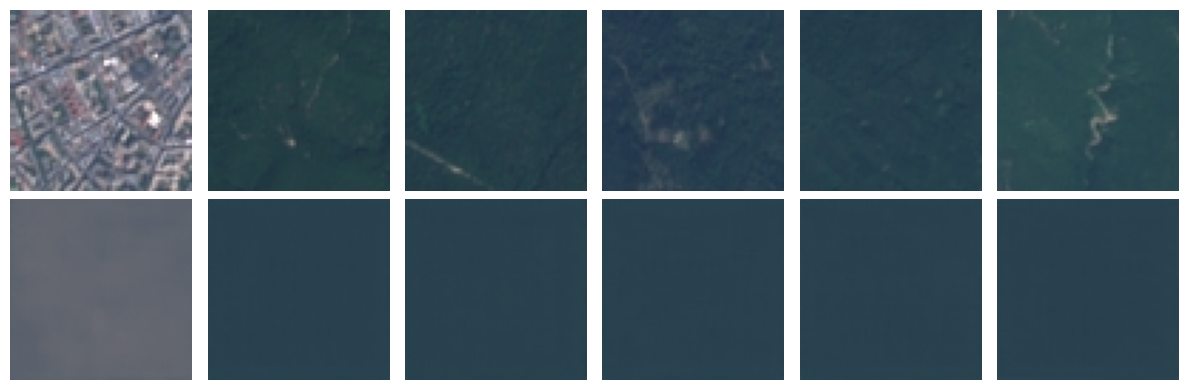

In [8]:
def show_recon(model,loader,n=6):
    model.eval()
    x,_=next(iter(loader))
    x=x[:n].to(device)
    with torch.no_grad():
        recon,_,_,_=model(x)
    x=(x.cpu().permute(0,2,3,1)*0.5+0.5).clamp(0,1)
    r=(recon.cpu().permute(0,2,3,1)*0.5+0.5).clamp(0,1)
    plt.figure(figsize=(12,4))
    for i in range(n):
        plt.subplot(2,n,i+1);plt.imshow(x[i]);plt.axis("off")
        plt.subplot(2,n,i+1+n);plt.imshow(r[i]);plt.axis("off")
    plt.tight_layout();plt.show()

show_recon(model,val_loader)


c:\Users\duody\anaconda3\envs\envMLGPU\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


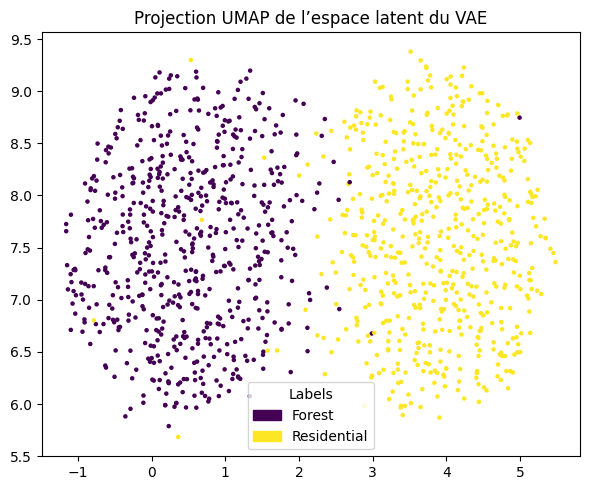

In [12]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

model.eval()
latents, labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        mu, logvar = model.enc(x)
        z = model.reparam(mu, logvar)
        latents.append(z.cpu())
        labels.append(y)

z_all = torch.cat(latents)
y_all = torch.cat(labels)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
z_2d = reducer.fit_transform(z_all)

plt.figure(figsize=(6,5))
scatter = plt.scatter(z_2d[:,0], z_2d[:,1], c=y_all, cmap='viridis', s=5)

classes = np.unique(y_all)
colors = [scatter.cmap(scatter.norm(i)) for i in classes]
label_names = {0: "Forest", 1: "Residential"}
patches = [mpatches.Patch(color=c, label=label_names[int(i)]) for i, c in zip(classes, colors)]

plt.legend(handles=patches, title="Labels", loc="best")
plt.title("Projection UMAP de l’espace latent du VAE")
plt.tight_layout()
plt.show()


In [10]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader
import torch

ood_base = ImageFolder("../../data/OOD", transform=transform)
orig_to_new = {
    ood_base.class_to_idx["Forest"]: 0,
    ood_base.class_to_idx["DenseResidential"]: 1,
    ood_base.class_to_idx["MediumResidential"]: 1,
}

class RelabeledDataset(Dataset):
    def __init__(self, base, mapping):
        self.base = base
        self.mapping = mapping
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        return x, self.mapping[y]

rel_ood = RelabeledDataset(ood_base, orig_to_new)

idx_dense  = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["DenseResidential"]]
idx_medium = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["MediumResidential"]]
idx_forest = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["Forest"]]

ood_loader     = DataLoader(rel_ood, batch_size=64, shuffle=False)
dense_loader   = DataLoader(Subset(rel_ood, idx_dense),  batch_size=64, shuffle=False)
medium_loader  = DataLoader(Subset(rel_ood, idx_medium), batch_size=64, shuffle=False)
forest_loader  = DataLoader(Subset(rel_ood, idx_forest), batch_size=64, shuffle=False)

len(ood_base), len(idx_forest), len(idx_dense), len(idx_medium)


(120, 60, 30, 30)

In [11]:
def evaluate_vae(model, loader):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2, 2, dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            _, logits, _, _ = model(x)  
            preds = logits.argmax(1)
            ok += (preds == y).sum().item()
            tot += y.size(0)
            for t, p in zip(y.cpu(), preds.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm


acc_all, cm_all       = evaluate_vae(model, ood_loader)
acc_forest, cm_forest = evaluate_vae(model, forest_loader)
acc_dense, cm_dense   = evaluate_vae(model, dense_loader)
acc_medium, cm_medium = evaluate_vae(model, medium_loader)

print("OOD global acc:", round(acc_all,4))
print("Forest acc:", round(acc_forest,4))
print("DenseResidential acc:", round(acc_dense,4))
print("MediumResidential acc:", round(acc_medium,4))
print("CM OOD:\n", cm_all.numpy())
print("CM Forest:\n", cm_forest.numpy())
print("CM Dense:\n", cm_dense.numpy())
print("CM Medium:\n", cm_medium.numpy())


OOD global acc: 0.7167
Forest acc: 0.45
DenseResidential acc: 1.0
MediumResidential acc: 0.9667
CM OOD:
 [[26 34]
 [ 0 60]]
CM Forest:
 [[27 33]
 [ 0  0]]
CM Dense:
 [[ 0  0]
 [ 0 30]]
CM Medium:
 [[ 0  0]
 [ 1 29]]
